Noam Bassat, **308465434**

In [1]:
# Import libraries  
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from tensorflow.keras import layers
import cv2

# Part 1: 
Classification of the cell type out of 8 possible types



https://notebook.community/GoogleCloudPlatform/ml-design-patterns/04_hacking_training_loop/transfer_learning

## Load Data-Set
colorectal histology DS

This DS contains 5000 images sized 150X150X3

In [2]:
(train_, validation_), info  = tfds.load(
    'colorectal_histology',
    split=['train[:90%]', 'train[90%:]'], # 4500 images for train set and 500 images for test set
    shuffle_files=True, 
    as_supervised=True,
    with_info=True
)


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteKGKF4E/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [3]:
label_map = ['tumor','stroma','complex','lympho','debris','mucosa', 'adipose', 'background']

In [4]:
for img, label in validation_:
  validation_x = img
  validation_y = label

### Regular Data

Using only the given images - 5000 images.

 Preview of 5 examples from the validation dataset

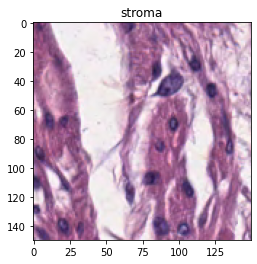

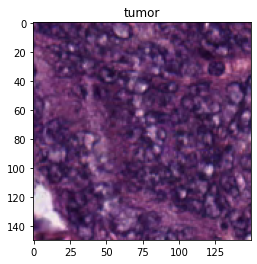

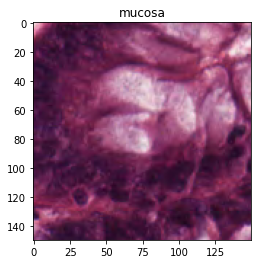

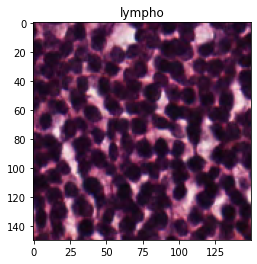

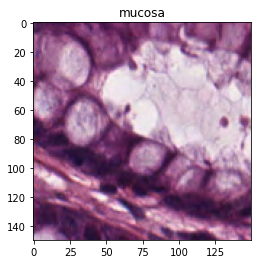

In [5]:

get_label_name = info.features['label'].int2str
for image, label in validation_.take(5):
  plt.figure()
  plt.imshow(np.array(image))
  plt.title(get_label_name(label))
  # 5 plots of the validation images with labels

In [6]:
# Input shape of a single image
info.features['image']

Image(shape=(150, 150, 3), dtype=tf.uint8)

#### Preprocessing Data

In [7]:
def label_format(image, label):
  return (image, tf.one_hot(label, depth=8))

train = train_.map(label_format)
validation = validation_.map(label_format)

train_batch = train.shuffle(1000) 
for image_batch, label_batch in train_batch.take(1): pass
image_batch = np.expand_dims(image_batch,0) # Fit the image size for the model input
image_batch.shape

(1, 150, 150, 3)

In [8]:
train = train.shuffle(1000).batch(32) # Regular train dataset
validation = validation.batch(32) # Regular validation dataset

### Data Augmentation
https://www.tensorflow.org/tutorials/images/data_augmentation

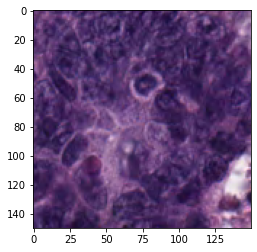

In [9]:
image, label = next(iter(train_))

IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
]) # Resizing and rescaeling the images

result = resize_and_rescale(image)
plt.imshow(result)

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
])
"""
Data Augmentation - by randomly rotating, flipping, and zooming each image from the train set
"""

'\nData Augmentation - by randomly rotating, flipping, and zooming each image from the train set\n'

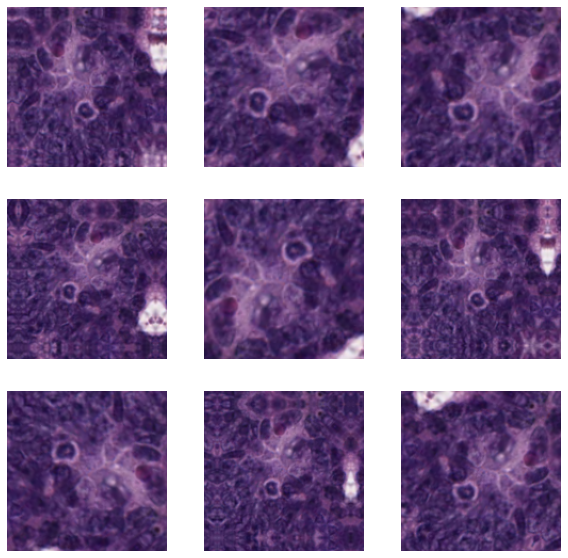

In [11]:
image = tf.expand_dims(image, 0) # adding a dimension
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [12]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds = prepare(train_, shuffle=True, augment=True) # Augmentation train set
val_ds = prepare(validation_)# Augmentation test set

## Generic methods

###  Compile and train the model

In [14]:
def compile_and_train_the_model(model, epochs_num, opt, loss_kind, data_aug):
     # Compile the model:
    model.compile(optimizer=opt,
                  loss=loss_kind,
                  
                  metrics=['accuracy'])
    
    if(data_aug!=0): # Data = data augmentation
       # Fit the model
      history = model.fit(

        train_ds,
        validation_data=val_ds,
        verbose=0,
        epochs=epochs_num,
        batch_size=128
      )

    else:# Data = regular data
      # Fit the model
      history = model.fit(
        train,
        validation_data=validation,
        verbose=0,
        epochs=epochs_num,
        batch_size=128
  )
    
    return history

### Plot Graphs

In [15]:

def plot_perfomance(history_num):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history_num.history['loss'],'r')
  plt.plot(history_num.history['val_loss'],'b')
  plt.title('Loss',fontsize=14)
  plt.xlabel('Epochs',fontsize=14)
  plt.legend(('loss','val_loss'))
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(history_num.history['accuracy'],'r')
  plt.plot(history_num.history['val_accuracy'],'b')
  plt.ylim([0, 1])
  plt.legend(('accuracy','val_accuracy'))
  plt.title('Accuracy',fontsize=12)
  plt.xlabel('Epochs',fontsize=12)
  plt.grid()
  

## The Models

#### Model 1
  Fine - tuning pre-trained VGG19:

  Sequential model:

  First layer - pre-trained VGG19 model (without its "top")

  New top: Flatten(), 256-Dense (ReLU), Dropout(0.5), 8-Dense (Softmax)freeze the weights in the first layer (of the new model (= the pre-trained VGG19 model))

    2,099,464 trainable parameters

    Optimizer = Adam

    Loss = Categorical Crossentropy

In [16]:
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model1 = Sequential(vgg_model)
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='softmax'))
model1.layers[0].trainable = False # Freeze the pretrained layer
model1.summary() 

loss_kind=tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
history1 = compile_and_train_the_model(model1, 50, opt, loss_kind,0)
history1.history['val_accuracy'][-1]


80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 2,099,464
Non-trainable params: 20,024,384
_________________________________________________________________


0.8859999775886536

##### Plot performance

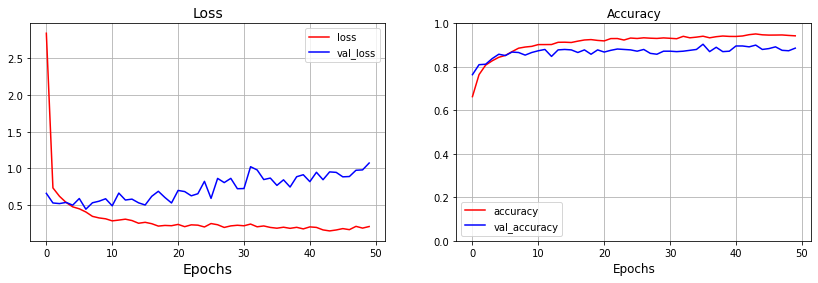

In [17]:
plot_perfomance(history1)


In [18]:
history1.history['accuracy'][-1]

0.9426666498184204

Model 1 looks unstable and overfitted

#### Model 2
  Fine - tuning pre-trained VGG19:

  Sequential model:

  First layer - pre-trained VGG19 model (without its "top")

  New top: Flatten(), 256-Dense (ReLU), Dropout(0.5), 8-Dense (Softmax)
  freeze the weights in the first layer (of the new model (= the pre-trained VGG19 model))

    2,099,464 trainable parameters

    Optimizer = SGD
    loss = Categorical Crossentropy


In [19]:
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model2 = Sequential(vgg_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='softmax'))
model1.layers[0].trainable = False # Freeze the pretrained layer
model2.summary() 
loss_kind=tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
history2 = compile_and_train_the_model(model2, 50, opt, loss_kind,0)
history2.history['val_accuracy'][-1]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 22,123,848
Non-trainable params: 0
_________________________________________________________________


0.9419999718666077

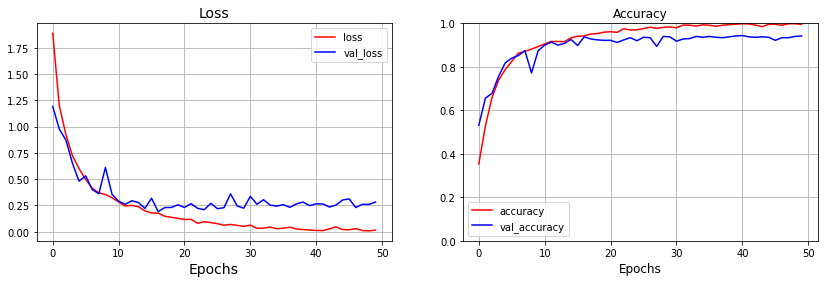

In [20]:
plot_perfomance(history2)

In [21]:
history2.history['accuracy'][-1]

0.995555579662323

Let's try to retrain the pre-trained layers

### Model 3
Trainable VGG19, with data augmentation used.

    Loss = Sparse Categorical Crossentropy
    Optimizer - Adam
    learning rate = e^-6

In [22]:
#rebuilding model1-like
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model3 = Sequential(vgg_model)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(8, activation='softmax'))
model3.summary()

opt = keras.optimizers.Adam(learning_rate=1e-06, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_kind=tf.keras.losses.SparseCategoricalCrossentropy()
history3 = compile_and_train_the_model(model3, 200, opt, loss_kind, 1)
history3.history['val_accuracy'][-1]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 22,123,848
Non-trainable params: 0
_________________________________________________________________


0.9599999785423279

In [23]:
history3.history['accuracy'][-1]

0.9635555744171143

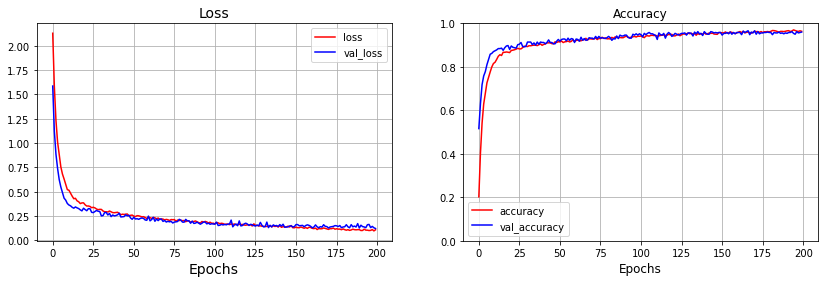

In [24]:
plot_perfomance(history3)

### Model 4
Model 2 + Data Augmentation

    Loss = Sparse Categorical Crossentropy
    Optimizer = SGD -  Gradient descent (with low momentum) optimizer
    learning Rate = e^-(6)

In [25]:
# Rebuilding model 2 with fine tuning
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model4 = Sequential(vgg_model)
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(8, activation='softmax'))
model4.summary()
loss_kind=tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
history4 = compile_and_train_the_model(model4, 200, opt, loss_kind,1)
history4.history['val_accuracy'][-1]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 22,123,848
Non-trainable params: 0
_________________________________________________________________


0.9620000123977661

In [26]:
history4.history['accuracy'][-1]

0.987333357334137

# New Section

#### Plot performance

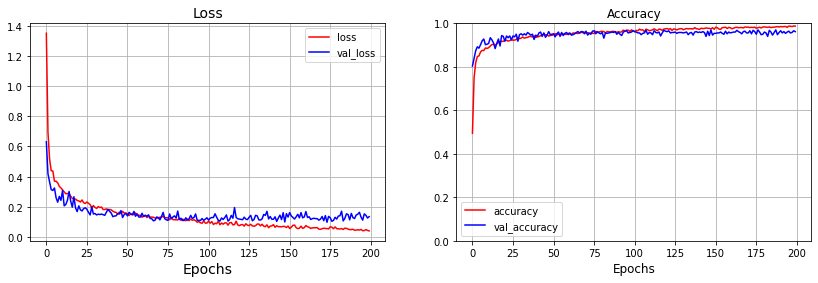

In [27]:
plot_perfomance(history4)

## Compare models performance

### Plot Perfomances

#### Train perfomances

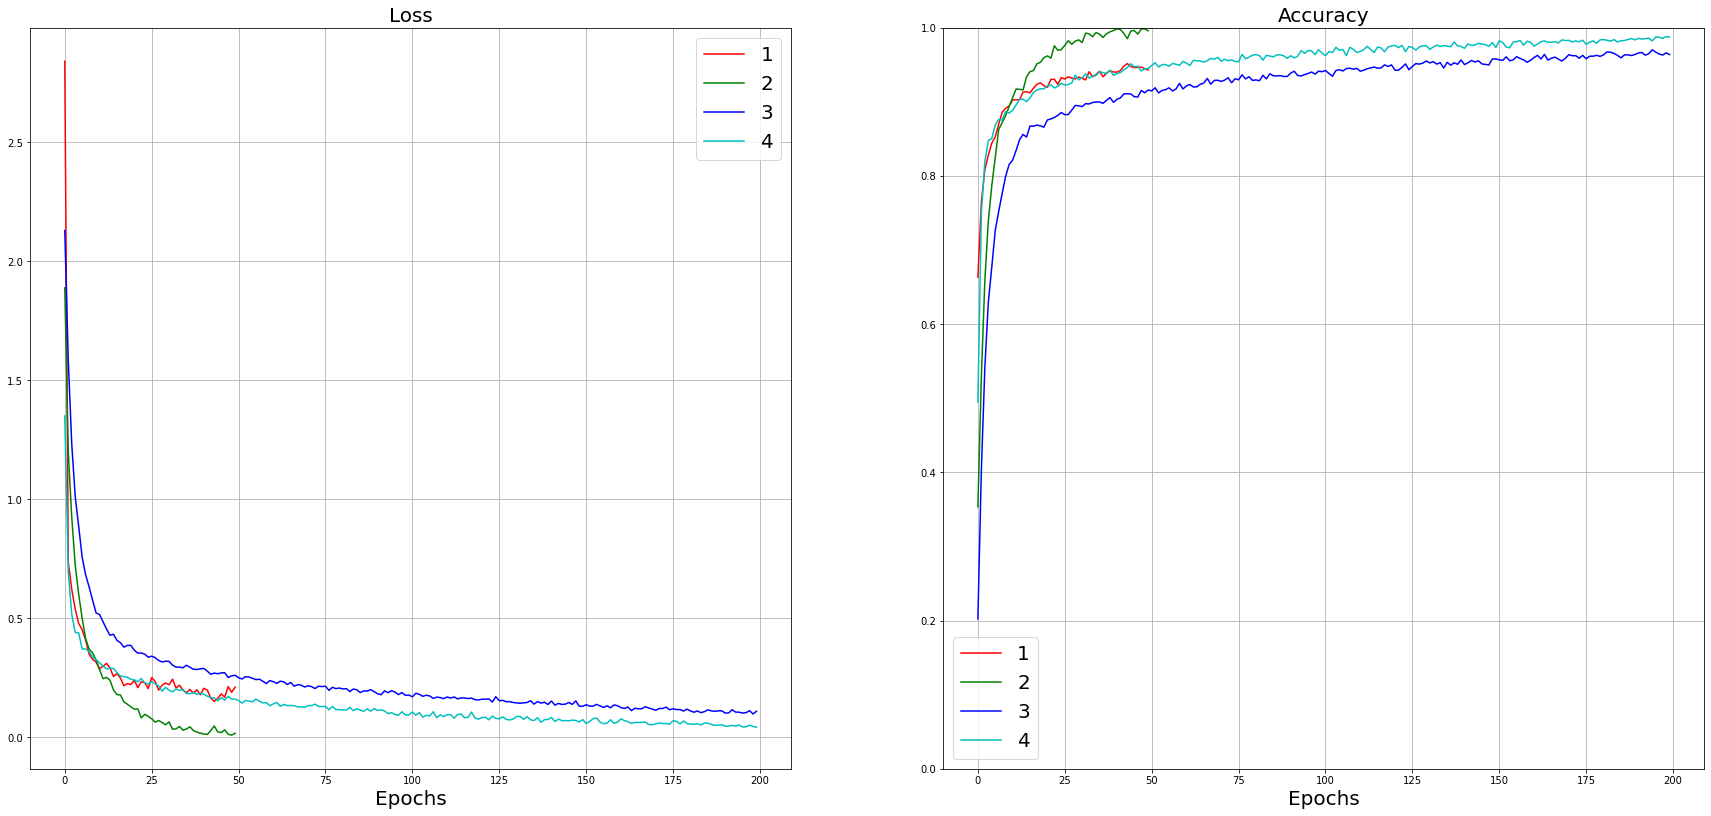

In [28]:
plt.figure(figsize=(30,30))

plt.subplot(2,2,1)
plt.plot(history1.history['loss'],'r',label = "1")
plt.plot(history2.history['loss'],'g',label = "2")
plt.plot(history3.history['loss'],'b',label = "3")
plt.plot(history4.history['loss'],'c',label = "4")
plt.title('Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend(('1','2','3','4'),fontsize=20)
plt.grid()

plt.subplot(2,2,2)
plt.plot(history1.history['accuracy'],'r',label = "1")
plt.plot(history2.history['accuracy'],'g',label = "2")
plt.plot(history3.history['accuracy'],'b',label = "3")
plt.plot(history4.history['accuracy'],'c',label = "4")
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend(('1','2','3','4'),fontsize=20)
plt.grid()


#### Validation perfomances

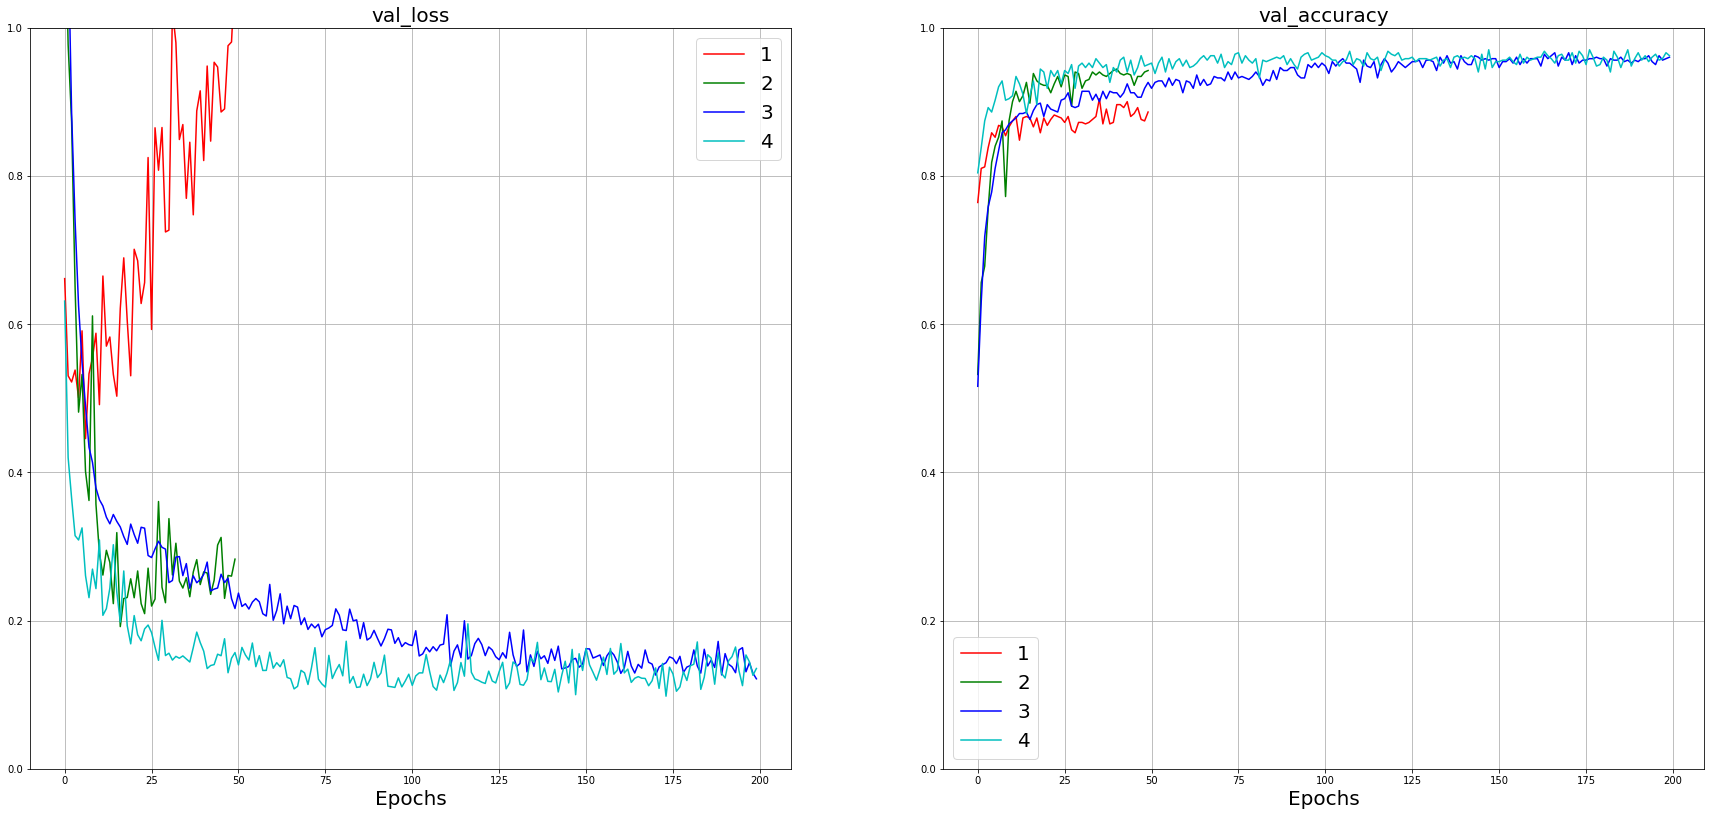

In [29]:
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
plt.plot(history1.history['val_loss'],'r',label = "1")
plt.plot(history2.history['val_loss'],'g',label = "2")
plt.plot(history3.history['val_loss'],'b',label = "3")
plt.plot(history4.history['val_loss'],'c',label = "4")


plt.ylim([0, 1])
plt.title('val_loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend(('1','2','3','4'),fontsize=20)
plt.grid()

plt.subplot(2,2,2)
plt.plot(history1.history['val_accuracy'],'r',label = "1")
plt.plot(history2.history['val_accuracy'],'g',label = "2")
plt.plot(history3.history['val_accuracy'],'b',label = "3")
plt.plot(history4.history['val_accuracy'],'c',label = "4")

plt.ylim([0, 1])
plt.title('val_accuracy',fontsize=20)
plt.legend(('1','2','3','4'),fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.grid()

### Comparison Table

<table>
  <tr>
    <th>Model</th>
    <th>Epochs</th>
    <th>Train accuracy</th>
    <th>Test accuracy</th>
  </tr>
    
  <tr> 
    <td> Model 1 </td>   <!-- Model -->
    <td>50</td> <!-- epochs -->
    <td> 0.942</td> <!-- train accuracy -->
    <td>0.885</td> <!-- test accuracy -->
  </tr>

    
   <tr> 
    <td> Model 2 </td>   <!-- Model -->
    <td>50</td> <!-- epochs -->
    <td> 0.995</td> <!-- train accuracy -->
    <td> 0.941 </td> <!-- test accuracy -->
  </tr>


  <tr> 
    <td> Model 3  </td>   <!-- Model -->
    <td>200</td> <!-- epochs -->
    <td>0.963 </td> <!-- train accuracy -->
    <td>0.959</td> <!-- test accuracy -->
  </tr>
  
  <tr> 
    <td> Model 4 </td>   <!-- Model -->
    <td>200</td> <!-- epochs -->
    <td> 0.987 </td> <!-- train accuracy -->
    <td >0.962 </td> <!-- test accuracy -->
  </tr>
</table>


                 CONCLUSION:

              The third model - which is Model_3 using data augmentation,
              gained the lowest overfitting and the highest 'test accuracy' rate.



## Model 3 performance

### Confusion Matrix

In [26]:

true_label = []
for image, label in validation_:
  true_label.append(label)
true_label = np.asarray(true_label)
y_pred = np.argmax(model3.predict(prepare(validation_)),axis=1) # Predict the validation set
M = confusion_matrix(true_label,y_pred) # Creating the confusion matrix

#### Confusion Matrix table

In [27]:
M

array([[40,  4,  4,  3,  3,  6,  1,  6],
       [ 0, 31,  5,  2,  6,  4,  2,  8],
       [ 4,  5, 29,  9,  6,  4,  8,  3],
       [ 5,  3,  7, 40,  1,  1,  5,  1],
       [ 1,  5,  6,  3, 39,  5,  2,  7],
       [ 5,  3,  2,  2,  3, 33,  7,  5],
       [ 3,  1,  5,  7,  3,  2, 32,  4],
       [10,  6,  3,  0,  6,  6,  3, 25]])

#### Confusion Matrix plot

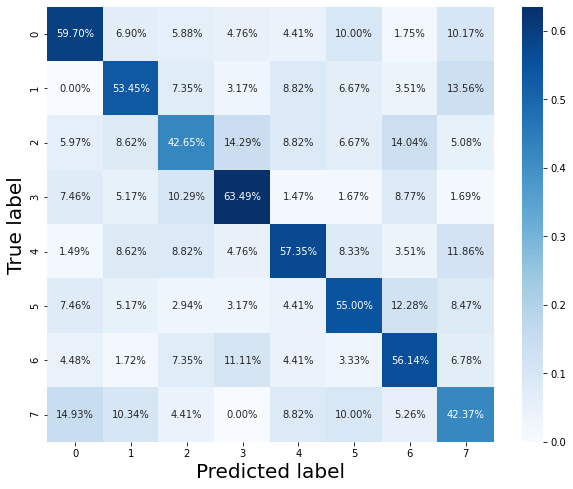

In [28]:
CM = M / M.sum(axis=1) # normalize each row (to sum = 1)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()


### Labels Plot



Using the t-SNE algorithm to reduce the dimensionality of the features (from 4096-D to 2-D), and using a scatter plot to visualize all samples in this 2-D *space*. Coloring the samples by their true label (use the set1 color map).

In [29]:
features_4096D = model3.predict(prepare(validation_))
features_2D = TSNE(n_components=2, random_state = 0).fit_transform(features_4096D)


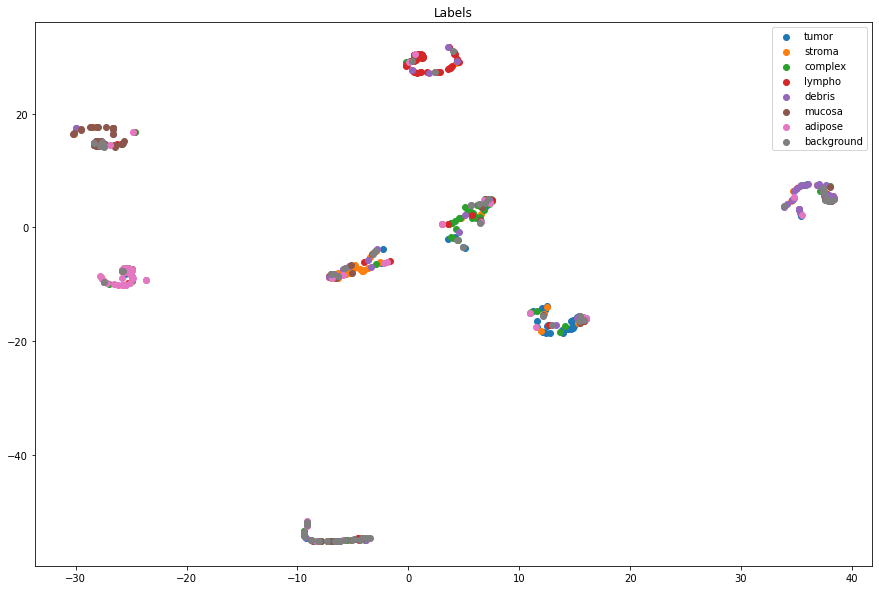

In [30]:
plt.figure(figsize=(15,10))
plt.title("Labels")
for i in range(8):
  x_label = features_2D[np.where(y_pred==i)]
  plt.scatter(x_label[:,0], x_label[:,1], cmap='set1', label= label_map[i])
plt.legend()
plt.show()

# **Part 2**

## Load new Data-Set
colorectal histology large DS

This DS contains 10 images sized 5000X5000X3

In [31]:
dataset, info = tfds.load(
    'ColorectalHistologyLarge',
    split=['test'],
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology_large/2.0.0.incomplete9H2N6D/colorectal_histology_large-test.tfrecord


Dataset colorectal_histology_large downloaded and prepared to /root/tensorflow_datasets/colorectal_histology_large/2.0.0. Subsequent calls will reuse this data.


### Preprocessing the data

In [32]:
image = next(iter(dataset))
images_list = []
for im in image:
  images_list.append((np.asarray(im['image']))) # Create an images list

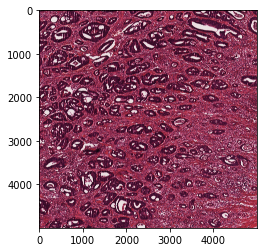

In [33]:
plt.imshow(images_list[1])

In [34]:
seg_images_list = []
cmap_images_list = []
# Create a list of 8 colors,one for each label in the dataset.
color_list=[(255, 0, 0), (255, 0,255) ,(255,255,255),(0,255, 0),	(0, 0,255),(255,255, 0),	(0,255,255),(0, 0,0)]	
for im in range(len(images_list)):
  large_image = np.asarray(images_list[im])
  large_image = np.reshape(large_image,(5000, 5000,3))
  # Create array of zeros for the "segmented labels image"
  seg_im = np.zeros_like(large_image)
  # Create array of zeros for tumor probability colored image
  cmap_im = np.zeros_like((large_image))

  larger_image = np.pad(large_image,((50,50),(50,50),(0,0)))
  # Adding a padding frame of zeros


  for i in range(0, large_image.shape[0], 75):
    # Steps of 75 pixels - means half overlapping
    for j in range(0, large_image.shape[1],75):

      single_patch_img = larger_image[i:150+i,j:150+j,:] 
            # Slice to 150X150X3 patches with overlapping
      single_patch_img = resize_and_rescale(single_patch_img) 
            # Resize and Rescale the patches
      single_patch_img = np.expand_dims(single_patch_img,0)
            # Adding a dimension
      single_prediction = model3.predict(single_patch_img)
            # Predict the patch's label

      for ind in range(3):
        # Add the class label color into the 'semented image'
        seg_im[i:i+150,j:j+150,ind] = color_list[np.argmax(single_prediction)][ind]
        cmap_im[i:i+150,j:j+150,ind] = 255 - single_prediction[0][ind]*255
        # Add the Tumor's probability into the 'cmap image'
        

  
  seg_images_list.append(seg_im)
  cmap_images_list.append(cmap_im)

https://www.youtube.com/watch?v=7IL7LKSLb9I

## Plot labels

In [35]:

def plot_images(cmap1, colored_images_list, flag):
  for i in range(10):
    plt.figure(figsize=(40, 40))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(images_list[i])
    ax1.set_title("Original img")
    gray = cv2.cvtColor(colored_images_list[i], cv2.COLOR_BGR2GRAY)
    img=ax2.imshow(gray, cmap=cmap1)
    ax2.set_title("Labeled img")
    if(flag!=0): ax2.set_title("Tumor Probability img")
    values = ["0","","","","","8"]
    # values for the colorbar of the segmented images

    if(flag!=0): 
      linespace = (colored_images_list[i].max()/255)/8
      values = [0.0]
      for j in range(8): values.append(values[j]+linespace)
               # values for the colorbar of the tumor images
    cb = fig.colorbar(img,ax=ax2, spacing = 'proportional', filled = True)
    
    if(flag!=0): cb.ax.set_yticklabels(["{:4.2f}".format(i) for i in values])
    else: cb.ax.set_yticklabels(i for i in label_map) ###

  
    plt.show()


# Final Results

## Segmented images

<Figure size 2880x2880 with 0 Axes>

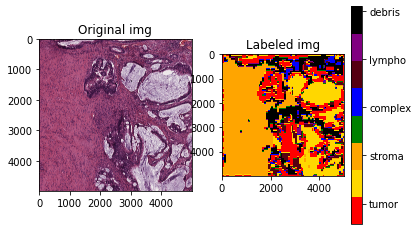

<Figure size 2880x2880 with 0 Axes>

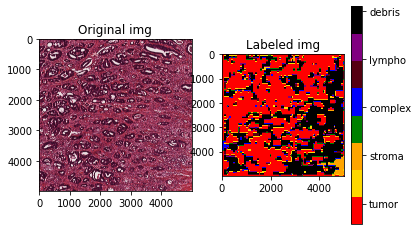

<Figure size 2880x2880 with 0 Axes>

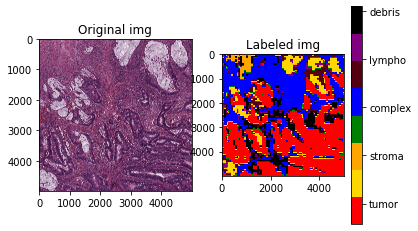

<Figure size 2880x2880 with 0 Axes>

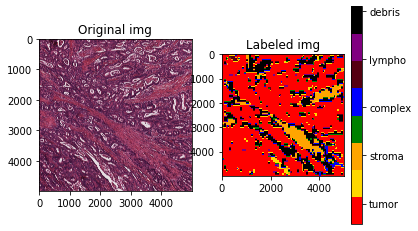

<Figure size 2880x2880 with 0 Axes>

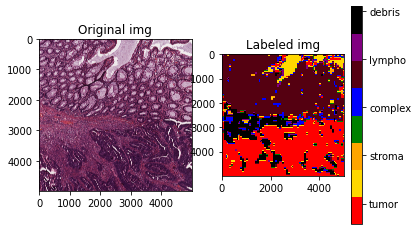

<Figure size 2880x2880 with 0 Axes>

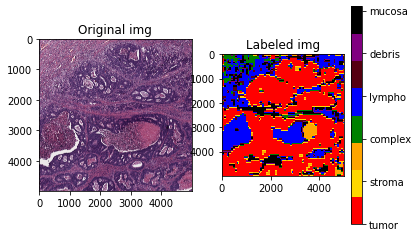

<Figure size 2880x2880 with 0 Axes>

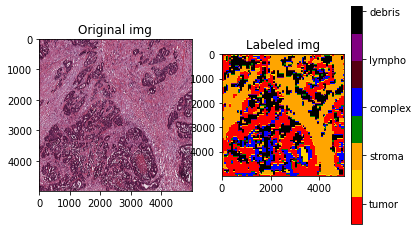

<Figure size 2880x2880 with 0 Axes>

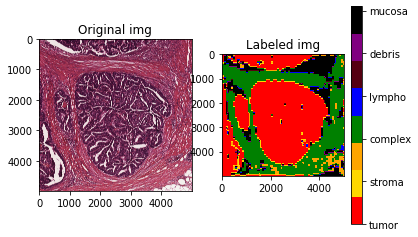

<Figure size 2880x2880 with 0 Axes>

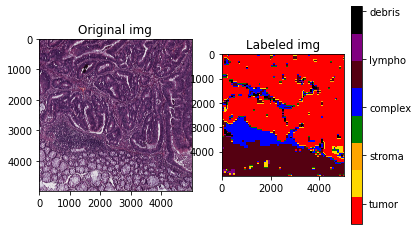

<Figure size 2880x2880 with 0 Axes>

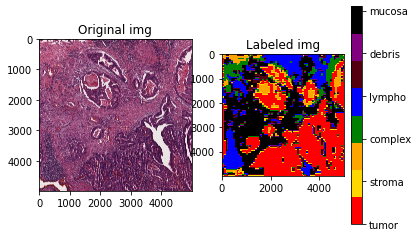

In [36]:

colors =["red","gold", "orange", 
         "green", "blue",  
        "#550011", "purple",
         "black"]
  
cmap1 = cm.colors.ListedColormap(colors)

plot_images(cmap1, seg_images_list, 0)

## Tumor probabilities images

<Figure size 2880x2880 with 0 Axes>

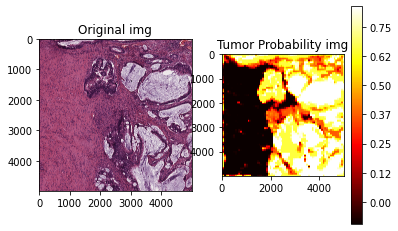

<Figure size 2880x2880 with 0 Axes>

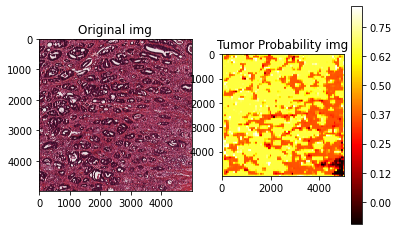

<Figure size 2880x2880 with 0 Axes>

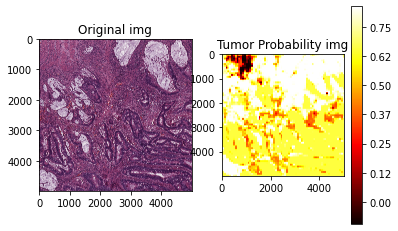

<Figure size 2880x2880 with 0 Axes>

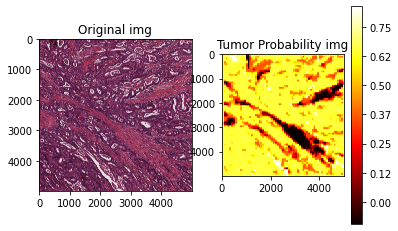

<Figure size 2880x2880 with 0 Axes>

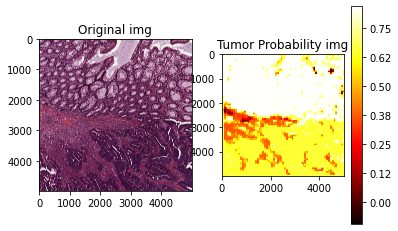

<Figure size 2880x2880 with 0 Axes>

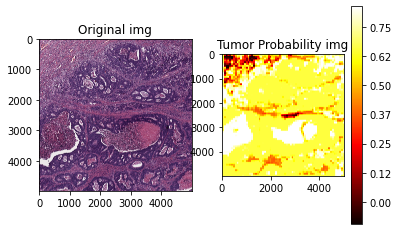

<Figure size 2880x2880 with 0 Axes>

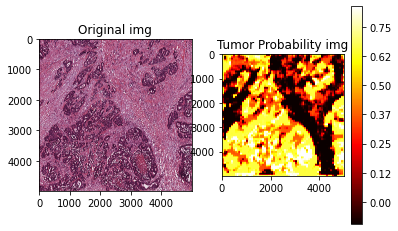

<Figure size 2880x2880 with 0 Axes>

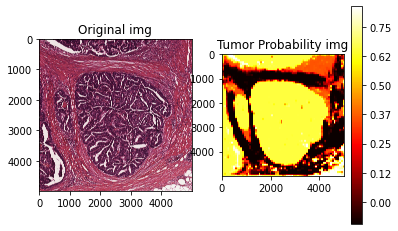

<Figure size 2880x2880 with 0 Axes>

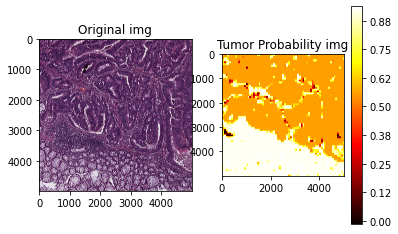

<Figure size 2880x2880 with 0 Axes>

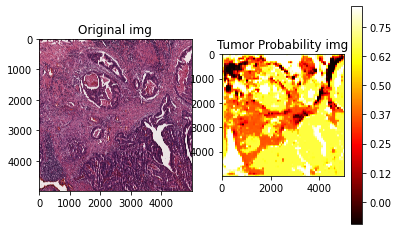

In [37]:
plot_images('hot', cmap_images_list, 1)

https://www.geeksforgeeks.org/matplotlib-colors-listedcolormap-class-in-python/